### План:

**1) Загрузка данных с сайта IRI, обработка, формирование фичей.
Прогноз Профетом на +3 года. Запись результатов, запись данных нулевой модели.**

**2) Загрузка притоков, сбросов, уровней с отчетов и созвездия. Обработка, заполнение данных, смещение для полного соответствия.**

**3) Объединение в один фрейм. Сохранение фичей, таргетов.**

# Этап №1

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xarray as xr #Для чтения данных с сайта IRI
from datetime import datetime as dt
import pyodbc #Для загрузки данных из базы

#Для чтения doc файлов - понадобится, чтобы загрузить статистику
import io
import csv
from docx import Document

#Укажем номер прогнозной модели.
#Он также означает на какое колличество месяцев вперед нужно сместить дату, чтобы получить пронгозные данные
lag = 6

#Дата запуска кода - для сохранения результатов с указанием даты
current_date = str(dt.now())[:10]

In [2]:
#Закачаем актуальные данные с IRI
#Укажем долготу и широту для которых хотим получить прогноз IRI
dolg = ['89.0', '118.0'];
shir = ['49', '60'];

GES_name = {'IRK': 'Иркутская ГЭС', 'SHA': 'Саяно-Шушенская ГЭС', 'KRA': 'Красноярская ГЭС',
            'BRA': 'Братская ГЭС', 'UIM': 'Усть-Илимская ГЭС', 'BOG': 'Богучанская ГЭС'};

url = f"""http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/\
.PENTAD_SAMPLES/.MONTHLY/.prec/\
X/{dolg[0]}/{dolg[1]}/RANGEEDGES/\
Y/{shir[0]}/{shir[1]}/RANGEEDGES/\
dods""";

ddos = xr.open_dataset(url, decode_times=False);
ddos['S'].attrs['calendar'] = '360_day';
ddos = xr.decode_cf(ddos, decode_times=True);

ddos = ddos.rename({'S': 'Дата', #Forecast_reference_time. Grid: /S (months since 1960-01-01) ordered (0000 1 Apr 2011) to (0000 1 Mar 2022) by 1.0 N= 132 pts :grid
                    #сетка число месяцев месяцев с 1 января 1960 г. с 0000 1 апреля 2011 г. по 0000 1 марта 2022 г.
                    'L': 'lead', #L. Grid: /L (months) ordered (0.5 months) to (9.5 months) by 1.0 N= 10 pts :grid
                    #сетка месяцев от 0,5 месяцев 9,5 месяцев
                    'M': 'member', #M. Grid: /M (unitless) ordered (1.0) to (28.0) by 1.0 N= 28 pts :grid
                    #сетка моделей (безразмерная от 1,0 до 28,0). IRI агрегирует 28 результатов других моделей. Далее мы их усредним, чтобы снизить ошибку.
                    'X': 'lon', #Longitude (longitude). Grid: /X (degree_east) ordered (89E) to (118E) by 1.0 N= 30 pts :grid
                    #Долгота упорядочена 89E до 118E
                    'Y': 'lat' #Latitude (latitude). Grid: /Y (degree_north) ordered (49N) to (60N) by 1.0 N= 12 pts :grid
                    #Широта упорядочена от 49N до 60N
                   });

ddos['lead'] = (ddos['lead']-0.5).astype('int'); #Значения записаны ка 0.5, 1.5, ... приводим к целы числам. Зачем - не понял
ddos['Дата'] = pd.to_datetime(ddos['Дата'].values.astype(str), yearfirst=True);
ddos

<xarray.Dataset>
Dimensions:  (lat: 12, lead: 10, lon: 30, member: 28, Дата: 133)
Coordinates:
  * Дата     (Дата) datetime64[ns] 2011-04-01 2011-05-01 ... 2022-04-01
  * member   (member) float32 1.0 2.0 3.0 4.0 5.0 ... 24.0 25.0 26.0 27.0 28.0
  * lead     (lead) int64 0 1 2 3 4 5 6 7 8 9
  * lon      (lon) float32 89.0 90.0 91.0 92.0 93.0 ... 115.0 116.0 117.0 118.0
  * lat      (lat) float32 49.0 50.0 51.0 52.0 53.0 ... 56.0 57.0 58.0 59.0 60.0
Data variables:
    prec     (Дата, lead, member, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [3]:
#Запишем всё в фрейм
fullda = ddos.to_dataframe()

#Для близжайших прогнозных месяцев запишем данные прогнозных моделей с минимально известным смещением
#Если lag=6, то на месяц вперед мы запишем данные с lag=1, на два месяца вперед lag=2 и далее
for i in range(1, lag):
    fullda.loc[(slice(None), 6, slice(None), slice(None),
                fullda.index.get_level_values(4).unique()[-i]), 'prec'] = fullda.loc[(slice(None), i, slice(None), slice(None),
                                                                                      fullda.index.get_level_values(4).unique()[-1]), 'prec'].values;
fullda.head()  

prec
lat  lead lon  member Дата               
49.0 0    89.0 1.0    2011-04-01  1.90944
                      2011-05-01  2.42001
                      2011-06-01  2.53503
                      2011-07-01  1.54278
                      2011-08-01  0.87615

In [4]:
#Мы будем использовать прогнозную модель в соответствии с выбранным в самом начале "lag"
fullda = fullda.loc[(slice(None), 6, slice(None))];
fullda.head()

prec
lat  lon  member Дата               
49.0 89.0 1.0    2011-04-01  1.10511
                 2011-05-01  1.10619
                 2011-06-01  0.84996
                 2011-07-01  0.63018
                 2011-08-01  0.48357

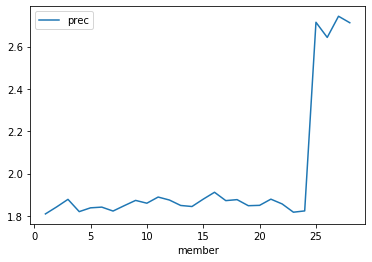

In [5]:
#Это прогнозные осадки в среднем для каждой группы
fullda.groupby('member').mean().plot();

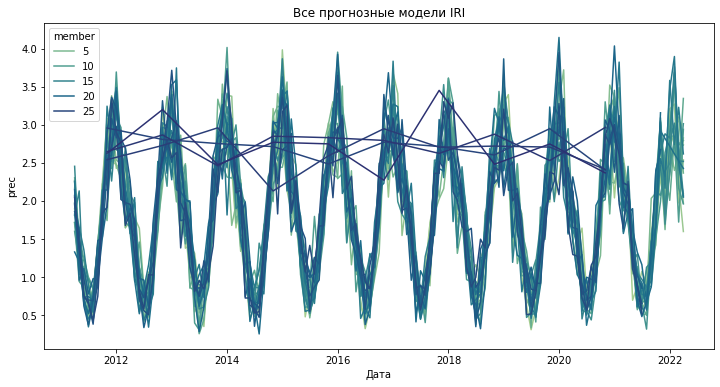

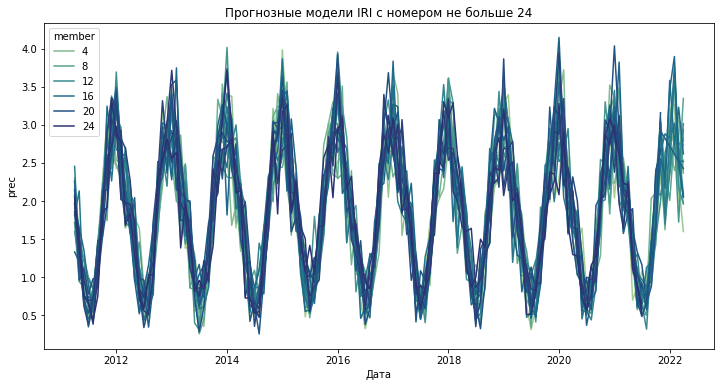

In [6]:
plt.subplots(figsize=(12,6));
sns.lineplot(data=fullda.groupby(['Дата', 'member']).mean(1), y='prec', x='Дата', hue='member', palette='crest');
plt.title('Все прогнозные модели IRI');
plt.savefig(f'../data/Исходные данные/Данные с сайта IRI/Графики/{current_date} Пргнозные модели IRI.png', dpi=200);
plt.show()

plt.subplots(figsize=(12,6));
sns.lineplot(data=fullda.loc[fullda.index.get_level_values(2)<=24].groupby(['Дата', 'member']).mean(1), y='prec', x='Дата', hue='member', palette='crest');
plt.title('Прогнозные модели IRI с номером не больше 24');
plt.savefig(f'../data/Исходные данные/Данные с сайта IRI/Графики/{current_date} Прогнозные модели IRI с номером не больше 24.png', dpi=200);
plt.show()

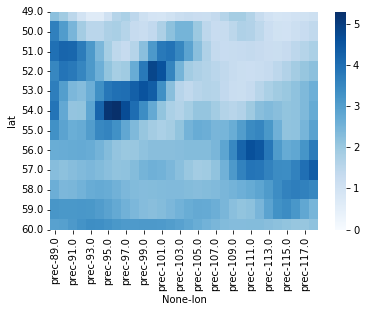

In [7]:
#Модели с номером 25 и выше завышают средние показатели. Избавимся от них
fullda = fullda.loc[fullda.index.get_level_values(2)<=24];

#Это прогнозные осадки в этот месяц+смещение (с разделением по географической сетке)
#Можно заметить где будет большего всего осадков
sns.heatmap(fullda.loc[fullda.index.get_level_values(3) == max(fullda.index.get_level_values(3))].groupby(['lat', 'lon']).mean().unstack(), cmap="Blues", vmin=0);

In [8]:
#Разделим те сектора, что нас интересуют
lats = np.linspace(49, 60, 12).reshape(3,4); #Указываем левую и правую границу, на сколько частей делим и новый формат
lons = np.linspace(89, 118, 30).reshape(3,10); #Указываем левую и правую границу, на сколько частей делим и новый формат

print('Широта', lats, 'Долгота', lons, sep='\n')

Широта
[[49. 50. 51. 52.]
 [53. 54. 55. 56.]
 [57. 58. 59. 60.]]
Долгота
[[ 89.  90.  91.  92.  93.  94.  95.  96.  97.  98.]
 [ 99. 100. 101. 102. 103. 104. 105. 106. 107. 108.]
 [109. 110. 111. 112. 113. 114. 115. 116. 117. 118.]]


In [9]:
#Для новых секторов,что мы определили - посчитаем средние осадки
#Все модели усредним в один прогноз осадков
df_mean = pd.DataFrame();
for h in range(3):
    for j in range(3):
        #Используя loc срежем по долготе и широте нужный сектор
        prec_gr = fullda.loc[(slice(lats[j][0],lats[j][-1]),
                              slice(lons[h][0],lons[h][-1]),
                              slice(None)
                             )].groupby('Дата');
        df_mean['Sec_'+str(1+h+j*3)] = prec_gr.mean().prec; #В результате для конкретного участка получим средние осадки
        #1+h+j*3 счетчик номера подсетки
            
df_mean.head()

,Sec_1,Sec_4,Sec_7,Sec_2,Sec_5,Sec_8,Sec_3,Sec_6,Sec_9
Дата,,,,,,,,,
2011-04-01,1.589989,2.810485,3.051070,1.073116,1.943756,2.581865,0.855280,1.441800,2.390435
2011-05-01,1.238201,2.198404,2.145847,0.656810,1.368867,1.635725,0.579954,0.792982,1.301832
2011-06-01,0.744035,1.558141,1.621923,0.443884,1.008537,1.179551,0.380857,0.483756,0.904007
2011-07-01,0.639773,1.195637,1.119042,0.339066,0.738717,0.780387,0.264979,0.347111,0.559780
2011-08-01,0.767590,1.073633,0.947410,0.472043,0.690080,0.724587,0.410856,0.404389,0.607161


In [10]:
#Попаравим даты. Добавим смещение. Еслим модель №6, то добавим 6 месяцев к дате
df_IRI = df_mean.shift(lag, freq='MS');
df_IRI.tail()

,Sec_1,Sec_4,Sec_7,Sec_2,Sec_5,Sec_8,Sec_3,Sec_6,Sec_9
Дата,,,,,,,,,
2022-06-01,1.957403,2.630444,2.506737,1.816120,2.096504,2.022584,1.432595,2.354329,2.586303
2022-07-01,2.677731,2.810333,2.357073,3.299888,2.625169,1.923410,2.985550,3.369918,2.929357
2022-08-01,3.468425,3.474846,2.183558,4.001974,2.771127,1.431914,3.703084,4.442761,2.824429
2022-09-01,3.131510,2.856715,2.091011,2.915858,1.917904,1.344073,2.270275,3.135190,2.481392
2022-10-01,2.287862,3.136271,2.741428,2.078462,2.274790,2.490277,1.390919,2.606087,2.945688


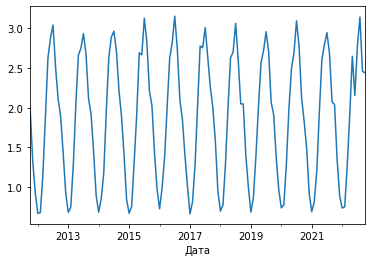

In [11]:
#Помесячные осадки
#Видно, что летом в Сибири осадков значительно больше - это подтверждается другими климатическими источниками
df_IRI.mean(1).plot();

In [12]:
#Профетом предскажем на +3 года вперед
from fbprophet import Prophet
df_prophet = pd.DataFrame();

for col in df_IRI.columns:
    pr_df = df_IRI[col].copy(deep=True);
    pr_df = pr_df.reset_index().rename(columns={'Дата': 'ds', col: 'y'});
    #Для этого метода нужно, чтобы столбец даты был назван ds, а таргет y
    #Обучим модель
    model_pr = Prophet(weekly_seasonality=False,
                       daily_seasonality=False).fit(pr_df);
    future_df = model_pr.make_future_dataframe(periods=36, freq='MS');
    forecast = model_pr.predict(future_df);
    df_prophet[col] = forecast[-36:]['yhat'].values;
    
df_prophet.index = forecast[-36:]['ds'];
df_prophet.index.name = 'Дата';
df_prophet = pd.concat([df_prophet, df_IRI], axis=0);
df_prophet.sort_values(by='Дата', inplace=True)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future 

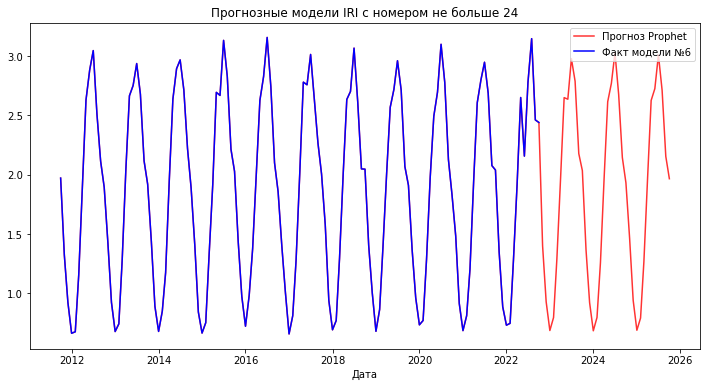

In [13]:
#Помесячные осадки +прогноз профетом
plt.subplots(figsize=(12,6));
sns.lineplot(data=df_prophet.mean(1), label='Прогноз Prophet', color='Red', alpha=0.8);
sns.lineplot(data=df_IRI.mean(1), label='Факт модели №'+str(lag), color='Blue');
plt.title('Прогнозные модели IRI с номером не больше 24');

In [14]:
#Сохраним результаты
df_IRI.to_excel(f'../data/Исходные данные/Данные с сайта IRI/{current_date} IRI прогноз модель №{lag}.xlsx');
df_prophet.to_excel(f'../data/Исходные данные/Данные с сайта IRI/{current_date} IRI прогноз + Prophet.xlsx');

In [15]:
#Повторим тоже самое для 0 модели, чтобы получить условно-фактические осадки
fact_IRI = ddos.to_dataframe();
fact_IRI = fact_IRI.loc[(slice(None), 0, slice(None))];
fact_IRI = fact_IRI.loc[fact_IRI.index.get_level_values(2)<=24];
fact_mean = pd.DataFrame();
for h in range(3):
    for j in range(3):
        fact_gr = fact_IRI.loc[(slice(lats[j][0],lats[j][-1]),
                                slice(lons[h][0],lons[h][-1]),
                                slice(None)
                                )].groupby('Дата');
        fact_mean['Sec_'+str(1+h+j*3)] = fact_gr.mean().prec;

fact_mean.to_excel(f'../data/Исходные данные/Данные с сайта IRI/{current_date} IRI факт.xlsx');
fact_mean.tail()

,Sec_1,Sec_4,Sec_7,Sec_2,Sec_5,Sec_8,Sec_3,Sec_6,Sec_9
Дата,,,,,,,,,
2021-12-01,0.711103,1.553434,1.813609,0.405532,1.050297,1.489227,0.360568,0.527777,1.339194
2022-01-01,0.681516,1.291683,1.226079,0.393674,0.809453,0.888077,0.305692,0.373879,0.720262
2022-02-01,0.755089,1.121904,1.330500,0.489954,0.787940,1.012524,0.391107,0.433591,0.810885
2022-03-01,1.671214,2.135528,2.205254,1.157235,1.592959,1.878138,0.926670,1.217192,1.671161
2022-04-01,2.477630,3.384600,2.977795,2.011204,2.561200,2.707230,1.650793,2.453710,2.810508


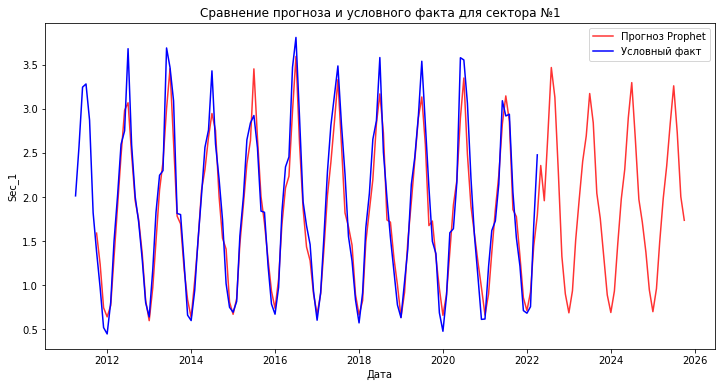

In [16]:
#Условно фактичекская (нулевая) модель и модель полугодовая с профетом на 3 года.
plt.subplots(figsize=(12,6));
sns.lineplot(data=df_prophet['Sec_1'], label='Прогноз Prophet', color='Red', alpha=0.8);
sns.lineplot(data=fact_mean['Sec_1'], label='Условный факт', color='Blue');
plt.title('Сравнение прогноза и условного факта для сектора №1');

# Этап №2

In [17]:
#Подготовка к обработке данных из word документов
def read_docx_tables(filename, tab_id=None, **kwargs):
    """
    Функция скорее всего взята с стаковерфлоу.
    Немного видоизменена и доработана под личные нужды.
    Считывает ворд файл, находит нужную таблицу и записывает как csv
    """
    def read_docx_tab(tab, **kwargs):
        vf = io.StringIO();
        writer = csv.writer(vf);
        
        for row in tab.rows:
            writer.writerow(cell.text for cell in row.cells);
            
        vf.seek(0);
        file_csv = pd.read_csv(vf, **kwargs);
        file_csv = file_csv.drop('Ср.-годов.', axis=1, errors='ignore'); #Не во всех таблицах есть этот показатель
        file_csv.rename(columns={[i for i in file_csv.columns if 'Месяц' in i][0]: 'Дата'}, inplace=True);
        file_csv = file_csv.set_index('Дата');
        file_csv = file_csv.drop(['Средн.','Мин','Мах'],axis=0);
        file_csv = file_csv.stack();
        file_csv.index = pd.to_datetime(file_csv.index.get_level_values(0) + '-' + file_csv.index.get_level_values(1) + '-01', yearfirst=True);
        file_csv.index.name = 'Дата'
        return file_csv

    doc = Document(filename);
    if tab_id is None:
        return [read_docx_tab(tab, **kwargs) for tab in doc.tables];
    else:
        try:
            return read_docx_tab(doc.tables[tab_id], **kwargs);
        except IndexError:
            print('Error: specified [tab_id]: {}  does not exist.'.format(tab_id));
            raise

pritok_otchet_eni = '../data/Исходные данные/Показатели ГЭС/Отчет для СГК по ГЭС Енис.docx';
pritok_otchet_ang = '../data/Исходные данные/Показатели ГЭС/Отчет для СГК по ГЭС Ангар.docx';

### Подключимся к базе данных

еще не готово

In [18]:
driver = r'FreeTDS';
server = r'pdc-lst-str-02.corp.suek.ru';
port = r'1433';
database = r'ces_tgk12' ;
username = r'sibgenco.local\omima';
password = r'VxjNOJV]!3';
tds = r'8.0';

conn = pyodbc.connect(f'\
DRIVER={driver};\
SERVER={server};\
PORT={port};\
DATABASE={database};\
UID={username};\
PWD={password};\
TDS_VERSION={tds};');

In [19]:
# Представление вьюшки
pd.read_sql('SELECT * FROM INFORMATION_SCHEMA.TABLES;',
            conn)

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,Ces_Tgk12,ComDis,TradeRegions,VIEW
1,Ces_Tgk12,ComDis,TemperatureTown,VIEW
2,Ces_Tgk12,ComDis,Hydrology,VIEW
3,Ces_Tgk12,ComDis,RgePlanGenerationAmount,VIEW
4,Ces_Tgk12,ComDis,GtpPlanConsume,VIEW
5,Ces_Tgk12,ComDis,SellNorem,VIEW
6,Ces_Tgk12,ComDis,ControlledSection,VIEW
7,Ces_Tgk12,ComDis,GtpPlanValue,VIEW
8,Ces_Tgk12,ComDis,RegionConsumeForecast,VIEW
9,Ces_Tgk12,ComDis,RegionPlanConsume,VIEW


In [20]:
"""qwerty = f"SELECT * FROM ComDis.Hydrology"  

GtpPlanValue = pd.read_sql(qwerty, conn)
display(GtpPlanValue.head())"""

'qwerty = f"SELECT * FROM ComDis.Hydrology"  \n\nGtpPlanValue = pd.read_sql(qwerty, conn)\ndisplay(GtpPlanValue.head())'

In [21]:
GES_name = {'IRK': 'Иркутская ГЭС', 'SHA': 'Саяно-Шушенская ГЭС', 'KRA': 'Красноярская ГЭС',
            'BRA': 'Братская ГЭС', 'UIM': 'Усть-Илимская ГЭС', 'BOG': 'Богучанская ГЭС'};

In [22]:
#Подготовка к обработке данных из созвездия
def df_soz(sheet_name, skiprows=1, header=0):
    df = pd.read_excel(GES_sozvezdie_parametres, skiprows=skiprows, sheet_name=sheet_name, header=header);
    df['Дата'] = pd.to_datetime(df['Год'].ffill().astype(int).astype(str) + '-' +
                                df['N месяца'].ffill().astype(int).astype(str) + '-01',
                               yearfirst=True);
    df = df.set_index('Дата');
    df.rename(columns={'Иркутская ГЭС': 'IRK', 'Саяно-Шушенская ГЭС': 'SHA', 'Красноярская ГЭС': 'KRA',
                       'Братская ГЭС': 'BRA', 'Усть-Илимская ГЭС': 'UIM', 'Богучанская ГЭС': 'BOG'},
              inplace=True);
    df.drop(columns=['Год', 'N месяца', 'N дня'], inplace=True);
    df = df[['IRK', 'SHA', 'KRA', 'BRA', 'UIM', 'BOG']]
    return df

#Загрузим данные по притокам, сбросам и уровню из созвездия
GES_sozvezdie_parametres = pd.ExcelFile('../data/Исходные данные/Показатели ГЭС/Обновить ГЭСы уровень сброс выработка.xlsx', engine='openpyxl')

#### Сброс

In [23]:
#Загрузим данные по расходу
#Фрейм с 2010 года, что бы потом обрезать по данным IRI 2011 год и были данные за предыдущий период на всякий случай
sbros = pd.DataFrame(index=(pd.date_range(start='1959-12-01',
                                          end='2019-11-30', freq='M') + pd.Timedelta(value=1, unit='day')));
sbros.index.name = 'Дата';
for i,p in zip(['IRK', 'SHA', 'KRA', 'BRA', 'UIM', 'BOG'],
               [1, 5, 7, 2, 3, 4]):
    sbros[i] = read_docx_tables(pritok_otchet_ang, tab_id=p);

#Заполним по Богучанской ГЭС средним, так как по ней данные только с 2014 года
sbros.fillna(method='bfill', inplace=True);
sbros.tail()

,IRK,SHA,KRA,BRA,UIM,BOG
Дата,,,,,,
2019-08-01,2311,2557.0,2862.0,3050.0,3138.0,3136.0
2019-09-01,2150,2236.0,3055.0,3117.0,3187.0,3255.0
2019-10-01,1834,1572.0,3412.0,3004.0,3117.0,3085.0
2019-11-01,1892,1316.0,3256.0,3101.0,3067.0,3152.0
2019-12-01,1797,1294.0,2677.0,3035.0,3029.0,3064.0


In [24]:
#Загрузим данные по расходам из созвездия
sbros_soz = df_soz('Сброс', 1, 0);
sbros_soz = sbros_soz.groupby('Дата').mean();
sbros_soz.tail()

,IRK,SHA,KRA,BRA,UIM,BOG
Дата,,,,,,
2021-12-01,2281.333333,1210.290323,3581.304348,5479.133333,3391.966667,3702.548387
2022-01-01,2032.903226,1209.677419,2416.129032,3928.064516,3714.516129,3538.709677
2022-02-01,1539.285714,1153.571429,2311.428571,3327.500000,3792.500000,3980.357143
2022-03-01,2056.612903,1457.129032,2314.838710,3222.709677,3528.548387,3834.838710
2022-04-01,2436.400000,1415.960000,2223.913043,3215.480000,3543.400000,3686.920000


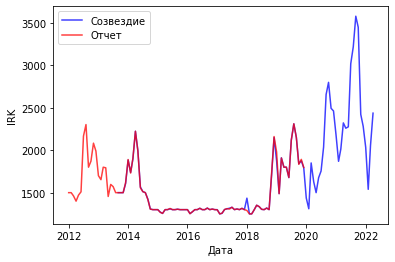

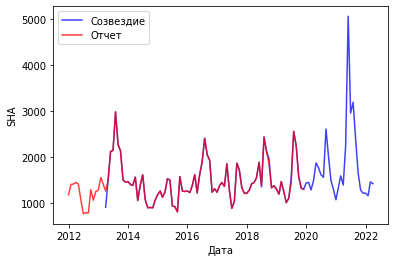

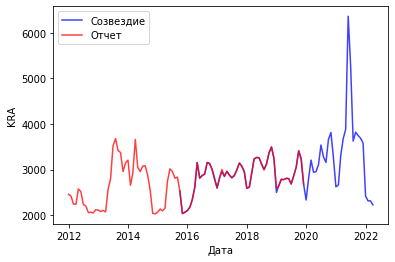

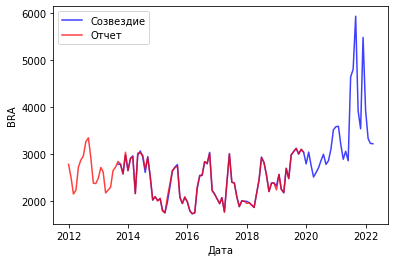

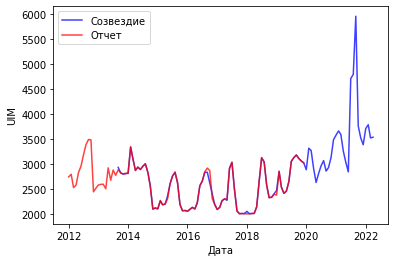

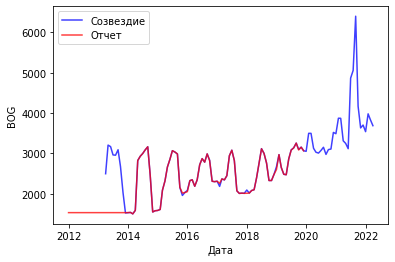

In [25]:
#Посмотрим на графики сбросов созвездия и отчетов
period = '|'.join([str(i) for i in range(2012, 2023)]);
for i in ['IRK', 'SHA', 'KRA', 'BRA', 'UIM', 'BOG']:
    ax1 = sns.lineplot(data=sbros_soz.loc[sbros_soz.index.astype(str).str.contains(period), i], color='Blue', alpha=0.75, label='Созвездие');
    ax2 = sns.lineplot(data=sbros.loc[sbros.index.astype(str).str.contains(period), i], color='Red', alpha=0.75, label='Отчет');
    plt.show()  

In [26]:
#Добавим в отчет данные созвездия
for d in sbros_soz[sbros_soz.index>='2016'].index:
    sbros.loc[d] = sbros_soz.loc[d].fillna(0);

#Дополнительная правка, так как по Красноярской и Усть-Илимской ГЭС много пропусков
sbros.loc[sbros.index>='2016', 'KRA'] = sbros.loc[sbros.index>='2016', 'KRA'].map(lambda x: max(x, 2000));
sbros.loc[sbros.index>='2016', 'UIM'] = sbros.loc[sbros.index>='2016', 'UIM'].map(lambda x: max(x, 2000));

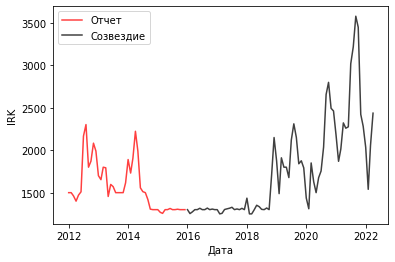

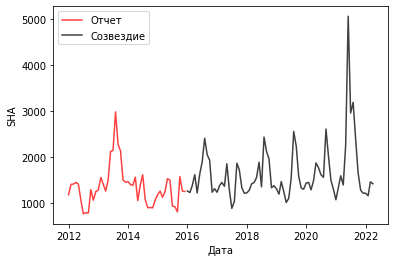

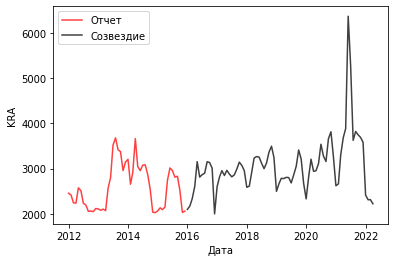

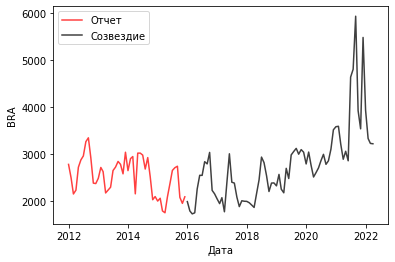

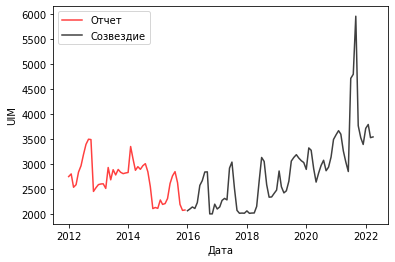

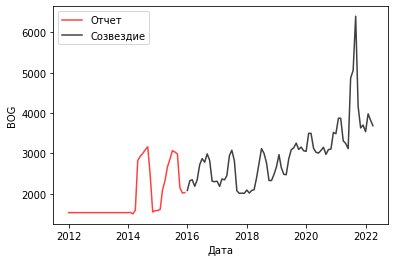

In [27]:
#Посмотрим на графики уровней созвездия и отчетов
period1 = '|'.join([str(i) for i in range(2012, 2016)]);
period2 = '|'.join([str(i) for i in range(2016, 2023)]);
for i in ['IRK', 'SHA', 'KRA', 'BRA', 'UIM', 'BOG']:
    ax1 = sns.lineplot(data=sbros.loc[sbros.index.astype(str).str.contains(period1), i], color='Red', alpha=0.75, label='Отчет');
    ax2 = sns.lineplot(data=sbros.loc[sbros.index.astype(str).str.contains(period2), i], color='Black', alpha=0.75, label='Созвездие');
    plt.show()

#### Приток

In [28]:
#Загрузим данные по притокам
pritok = pd.DataFrame(index=(pd.date_range(start='1959-12-01',
                                          end='2019-11-30', freq='M') + pd.Timedelta(value=1, unit='day')));
pritok.index.name = 'Дата';

#Енисейский каскад
pritok['IRK'] = read_docx_tables(pritok_otchet_eni, tab_id=1);
pritok['SHA'] = read_docx_tables(pritok_otchet_eni, tab_id=5);
pritok['KRA'] = read_docx_tables(pritok_otchet_eni, tab_id=6);

#Ангарский каскад
pritok['BRA'] = read_docx_tables(pritok_otchet_ang, tab_id=8);
pritok['UIM'] = read_docx_tables(pritok_otchet_ang, tab_id=9);
pritok['BOG'] = read_docx_tables(pritok_otchet_ang, tab_id=10);

pritok.tail()

,IRK,SHA,KRA,BRA,UIM,BOG
Дата,,,,,,
2019-08-01,3480,3070,1970,5741.0,3125.0,3238.0
2019-09-01,2150,1900,1810,3608.0,3177.0,3227.0
2019-10-01,1010,1360,1030,2843.0,3084.0,3127.0
2019-11-01,190,650,945,2400.0,3151.0,3074.0
2019-12-01,-85,540,360,2114.0,3075.0,3064.0


In [29]:
#Загрузим данные по притокам из созвездия
pritok_soz = df_soz('Приток', 1, 0);

#В созвездие нет данных за эту дату (весь месяц), поэтому добавим средние данные
pritok_soz.loc['2016-12-01', 'KRA'] = pritok_soz.loc[pritok_soz.index.month == 12, 'KRA'].mean();

pritok_soz = pritok_soz.groupby('Дата').mean();

#данных по притоку Усть-Илимская ГЭС нет, но экспертно мы знаем, что они равны сбросам Братской ГЭС
pritok_soz.loc[pritok_soz.index>='2016', 'UIM'] = sbros.loc[sbros.index>='2016', 'BRA'];

pritok_soz.tail()

,IRK,SHA,KRA,BRA,UIM,BOG
Дата,,,,,,
2021-12-01,-158.333333,515.161290,1547.391304,2619.666667,5479.133333,3431.129032
2022-01-01,539.285714,457.741935,1499.032258,2271.935484,3928.064516,3641.096774
2022-02-01,530.357143,418.928571,1385.714286,1726.964286,3327.500000,3830.142857
2022-03-01,359.354839,408.709677,2205.483871,2235.967742,3222.709677,3640.645161
2022-04-01,1120.000000,665.200000,2548.695652,3010.800000,3215.480000,3569.000000


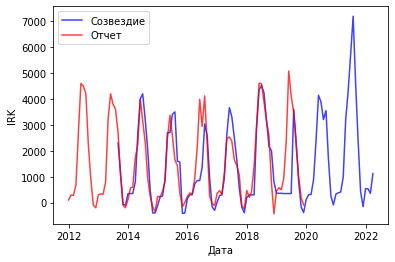

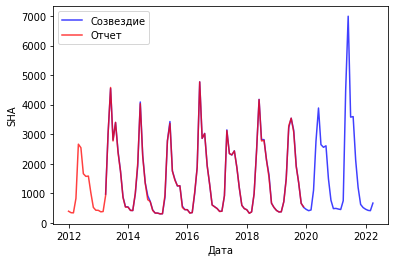

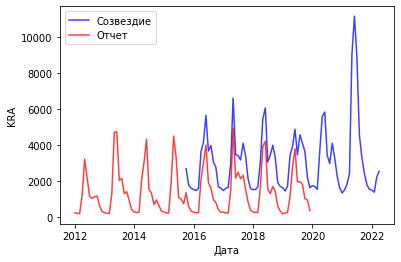

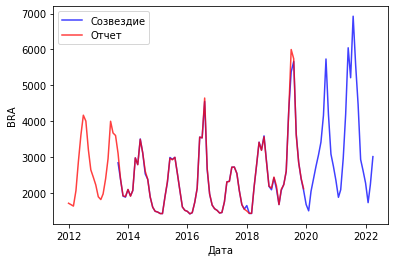

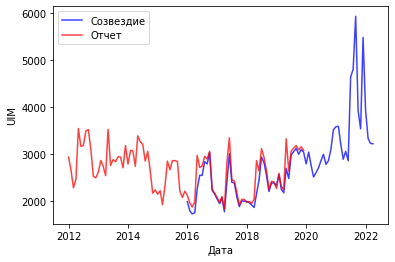

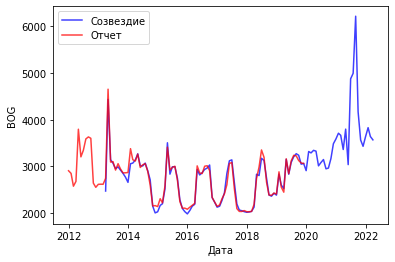

In [30]:
#Посмотрим на графики притоков созвездия и отчетов
period = '|'.join([str(i) for i in range(2012, 2023)])
for i in ['IRK', 'SHA', 'KRA', 'BRA', 'UIM', 'BOG']:
    ax1 = sns.lineplot(data=pritok_soz.loc[pritok_soz.index.astype(str).str.contains(period), i], color='Blue', alpha=0.75, label='Созвездие')
    ax2 = sns.lineplot(data=pritok.loc[pritok.index.astype(str).str.contains(period), i], color='Red', alpha=0.75, label='Отчет')
    plt.show()         

In [31]:
#Скорректируем данные отчета только для Красноярской ГЭС
pritok.loc[pritok.index<'2016', 'KRA'] += 1500

#Дополним данные информацией из созвездия
for i in pritok_soz.loc[pritok_soz.index>='2016'].index:
    pritok.loc[i] = pritok_soz.loc[i];

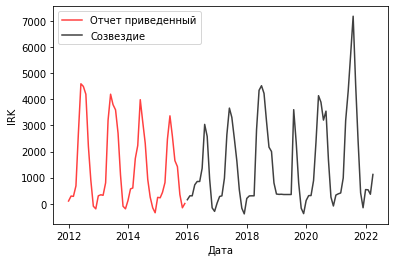

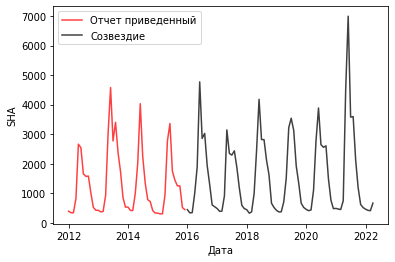

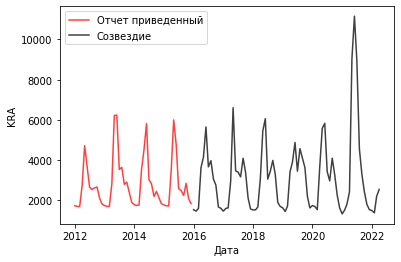

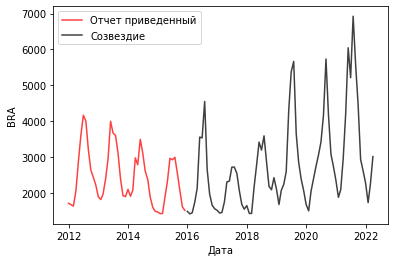

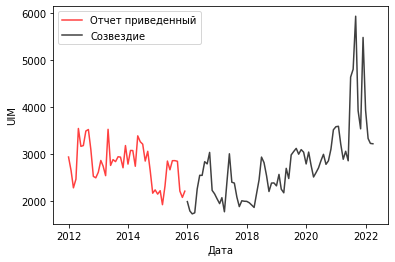

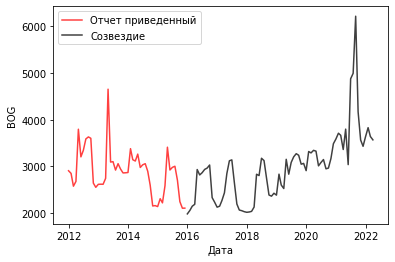

In [32]:
#Посмотрим на графики притоков созвездия и отчетов
period1 = '|'.join([str(i) for i in range(2012, 2016)]);
period2 = '|'.join([str(i) for i in range(2016, 2023)]);
for i in ['IRK', 'SHA', 'KRA', 'BRA', 'UIM', 'BOG']:
    ax1 = sns.lineplot(data=pritok.loc[pritok.index.astype(str).str.contains(period1), i], color='Red', alpha=0.75, label='Отчет приведенный');
    ax2 = sns.lineplot(data=pritok.loc[pritok.index.astype(str).str.contains(period2), i], color='Black', alpha=0.75, label='Созвездие');
    plt.show()     

#### Уровень

In [33]:
#Загрузим данные по уровням
uroven = pd.DataFrame(index=(pd.date_range(start='1959-12-01',
                                           end='2019-11-30', freq='M') + pd.Timedelta(value=1, unit='day')));
uroven.index.name = 'Дата';
for i,p in zip(['IRK', 'SHA', 'KRA', 'BRA', 'UIM', 'BOG'],
               [12, 16, 18, 13, 14, 15]):
    uroven[i] = read_docx_tables(pritok_otchet_ang, tab_id=p);

#Несколько пропусков заполним предыдущими значениями
uroven.fillna(method='ffill', inplace=True);
#Заполним пропуски по Богучанской ГЭС средним, так как по ней данные только с 2014 года
uroven.fillna(method='bfill', inplace=True);
uroven.tail()

,IRK,SHA,KRA,BRA,UIM,BOG
Дата,,,,,,
2019-08-01,456.76,535.31,236.93,398.26,295.85,207.79
2019-09-01,456.86,537.67,239.03,399.45,295.84,207.80
2019-10-01,456.86,536.19,239.95,399.63,295.85,207.74
2019-11-01,456.79,535.16,238.66,399.50,295.75,207.85
2019-12-01,456.64,531.91,237.16,399.08,295.85,207.74


In [34]:
#Загрузим данные по притокам из созвездия
uroven_soz = df_soz('Уровень', 1, 0);
uroven_soz = uroven_soz.groupby('Дата').agg('last');

#По Красноярской ГЭС много пропусков, а уровень стабильный весь год, Поэтому просто заполним предыдущими значениями
uroven_soz = uroven_soz.fillna(method='ffill');
uroven_soz = uroven_soz.fillna(method='bfill');
uroven_soz.tail()

,IRK,SHA,KRA,BRA,UIM,BOG
Дата,,,,,,
2021-12-01,456.80,527.55,234.66,401.37,295.66,207.48
2022-01-01,456.67,522.81,233.07,400.38,295.81,207.62
2022-02-01,456.59,517.20,231.62,399.55,295.40,207.54
2022-03-01,456.49,508.39,230.83,399.17,294.88,207.18
2022-04-01,456.38,500.27,231.16,399.36,294.57,207.04


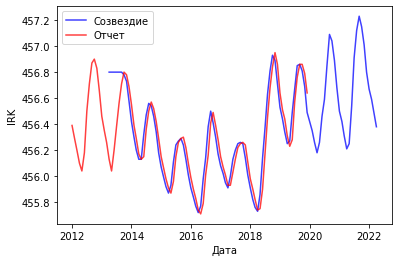

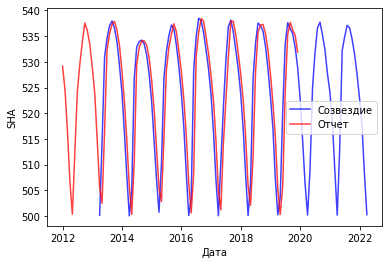

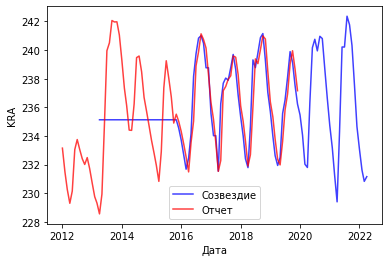

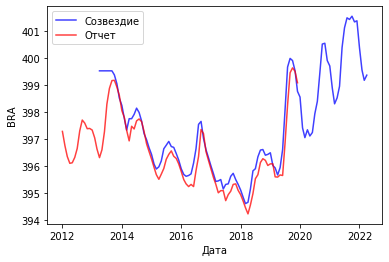

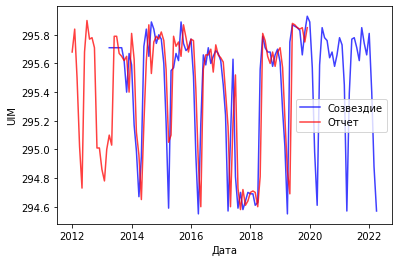

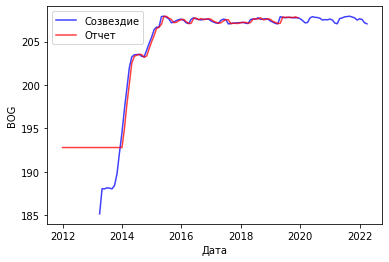

In [35]:
#Посмотрим на графики урвней созвездия и отчетов
period = '|'.join([str(i) for i in range(2012, 2023)]);
for i in ['IRK', 'SHA', 'KRA', 'BRA', 'UIM', 'BOG']:
    ax1 = sns.lineplot(data=uroven_soz.loc[uroven_soz.index.astype(str).str.contains(period), i], color='Blue', alpha=0.75, label='Созвездие');
    ax2 = sns.lineplot(data=uroven.loc[uroven.index.astype(str).str.contains(period), i], color='Red', alpha=0.75, label='Отчет');
    plt.show()    

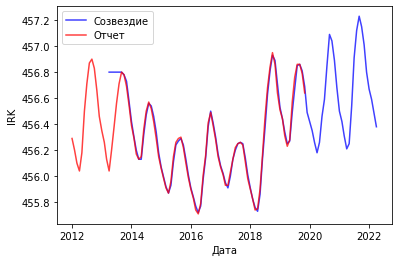

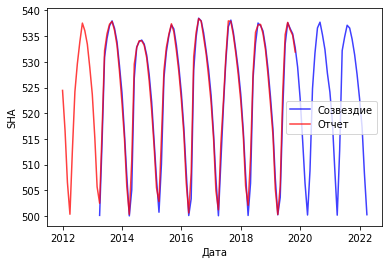

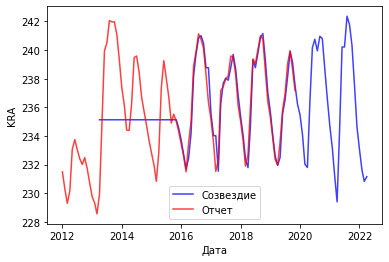

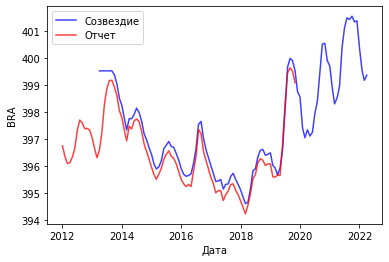

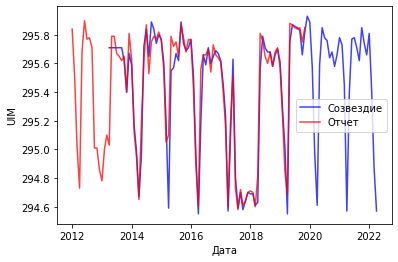

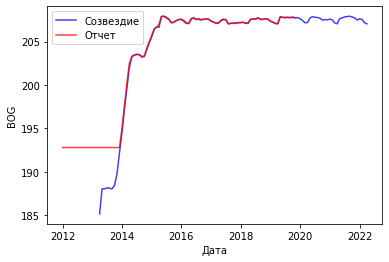

In [36]:
#Можно заметить, что данные отстают ровно на месяц.
#Перезапишем их со смещением и сделаем такиже операции, как с притоком, чтобы привести уровень к данным отчета.
uroven_new = uroven.shift(-1, freq='MS');
for i in ['IRK', 'SHA', 'KRA', 'BRA', 'UIM', 'BOG']:
    ax1 = sns.lineplot(data=uroven_soz.loc[uroven_soz.index.astype(str).str.contains(period), i], color='Blue', alpha=0.75, label='Созвездие');
    ax2 = sns.lineplot(data=uroven_new.loc[uroven_new.index.astype(str).str.contains(period), i], color='Red', alpha=0.75, label='Отчет');
    plt.show()

In [37]:
#Добавим данные из созвездия
for d in uroven_soz[uroven_soz.index>='2016'].index:
    uroven_new.loc[d] = uroven_soz.loc[d].fillna(0);

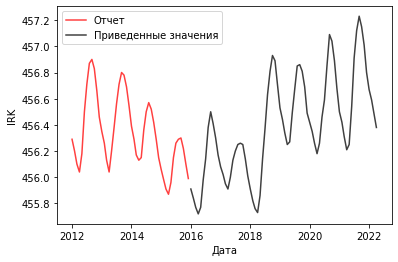

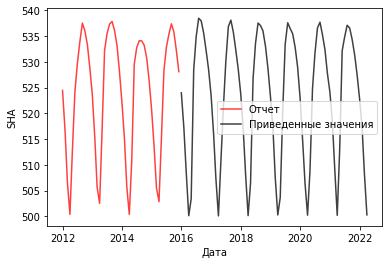

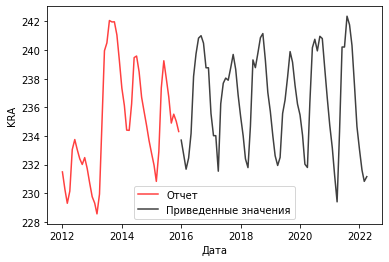

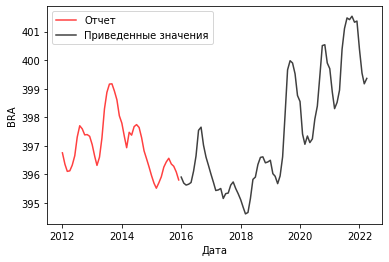

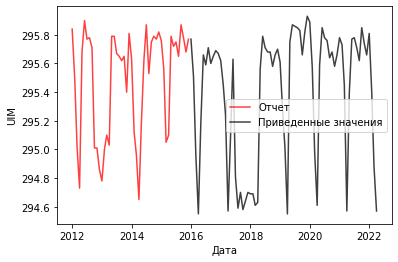

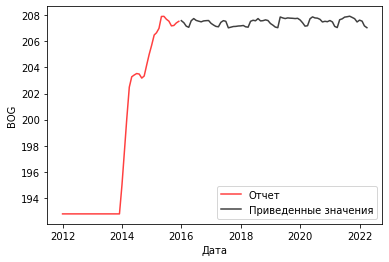

In [38]:
#Посмотрим на графики уровней созвездия и отчетов
period1 = '|'.join([str(i) for i in range(2012, 2016)]);
period2 = '|'.join([str(i) for i in range(2016, 2023)]);
for i in ['IRK', 'SHA', 'KRA', 'BRA', 'UIM', 'BOG']:
    ax1 = sns.lineplot(data=uroven_new.loc[uroven_new.index.astype(str).str.contains(period1), i], color='Red', alpha=0.75, label='Отчет');
    ax2 = sns.lineplot(data=uroven_new.loc[uroven_new.index.astype(str).str.contains(period2), i], color='Black', alpha=0.75, label='Приведенные значения');
    plt.show()

# Этап №3

In [39]:
#Объеденим данные и сохраним
ml = pd.concat([pritok.add_prefix('Приток_'),
                sbros.add_prefix('Сброс_'),
                uroven_new.add_prefix('Уровень_')],
               axis=1);
ml.dropna(thresh=16, inplace=True);
ml.to_excel(f'../data/Исходные данные/Показатели ГЭС/Свод после обработки/{current_date} Целевые переменные.xlsx');
ml.tail()

,Приток_IRK,Приток_SHA,Приток_KRA,Приток_BRA,Приток_UIM,Приток_BOG,Сброс_IRK,Сброс_SHA,Сброс_KRA,Сброс_BRA,Сброс_UIM,Сброс_BOG,Уровень_IRK,Уровень_SHA,Уровень_KRA,Уровень_BRA,Уровень_UIM,Уровень_BOG
Дата,,,,,,,,,,,,,,,,,,
2021-12-01,-158.333333,515.161290,1547.391304,2619.666667,5479.133333,3431.129032,2281.333333,1210.290323,3581.304348,5479.133333,3391.966667,3702.548387,456.80,527.55,234.66,401.37,295.66,207.48
2022-01-01,539.285714,457.741935,1499.032258,2271.935484,3928.064516,3641.096774,2032.903226,1209.677419,2416.129032,3928.064516,3714.516129,3538.709677,456.67,522.81,233.07,400.38,295.81,207.62
2022-02-01,530.357143,418.928571,1385.714286,1726.964286,3327.500000,3830.142857,1539.285714,1153.571429,2311.428571,3327.500000,3792.500000,3980.357143,456.59,517.20,231.62,399.55,295.40,207.54
2022-03-01,359.354839,408.709677,2205.483871,2235.967742,3222.709677,3640.645161,2056.612903,1457.129032,2314.838710,3222.709677,3528.548387,3834.838710,456.49,508.39,230.83,399.17,294.88,207.18
2022-04-01,1120.000000,665.200000,2548.695652,3010.800000,3215.480000,3569.000000,2436.400000,1415.960000,2223.913043,3215.480000,3543.400000,3686.920000,456.38,500.27,231.16,399.36,294.57,207.04
